## This notebook is used for testing pytorch dataset and dataloader

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
import warnings
warnings.filterwarnings("ignore")

In [6]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import albumentations
import torch
## customized package
from torch.utils.data import dataloader
from inputPipeline_stiching import PandaPatchDataset, crossValDataloader, data_transform
from torchvision import transforms, utils

### Dataset

In [10]:
data_dir = './panda-36x256x256-tiles-data-spine/train'
csv_file = './panda-36x256x256-tiles-data-spine/4_fold_whole_train.csv'
# SAMPLE = './input/prostate-cancer-grade-assessment/sample_submission.csv'

In [29]:
def data_transform():
    tsfm = albumentations.Compose([
        albumentations.Transpose(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20),
        albumentations.RandomBrightnessContrast()
    ])
    return tsfm

In [30]:
sz = 256
bs = 1
folds = 4
tsfm = data_transform()
# tsfm = None
dataset = PandaPatchDataset(csv_file, data_dir, sz, transform=tsfm, N = 36, rand = False)
crossValData = crossValDataloader(csv_file, dataset, bs)

### Dataloader

In [31]:
dataloader,_= crossValData(0)

In [32]:
data = iter(dataloader).next()
print("image size:{}, target sise:{}.".format(data['img'].size(), data['isup_grade'].size()))

image size:torch.Size([1, 3, 1536, 1536]), target sise:torch.Size([1, 5]).


### Plot data batch

In [33]:
grid = utils.make_grid(1-data['img'], nrow = 12, normalize = True) # normalize map image back to [0, 1]

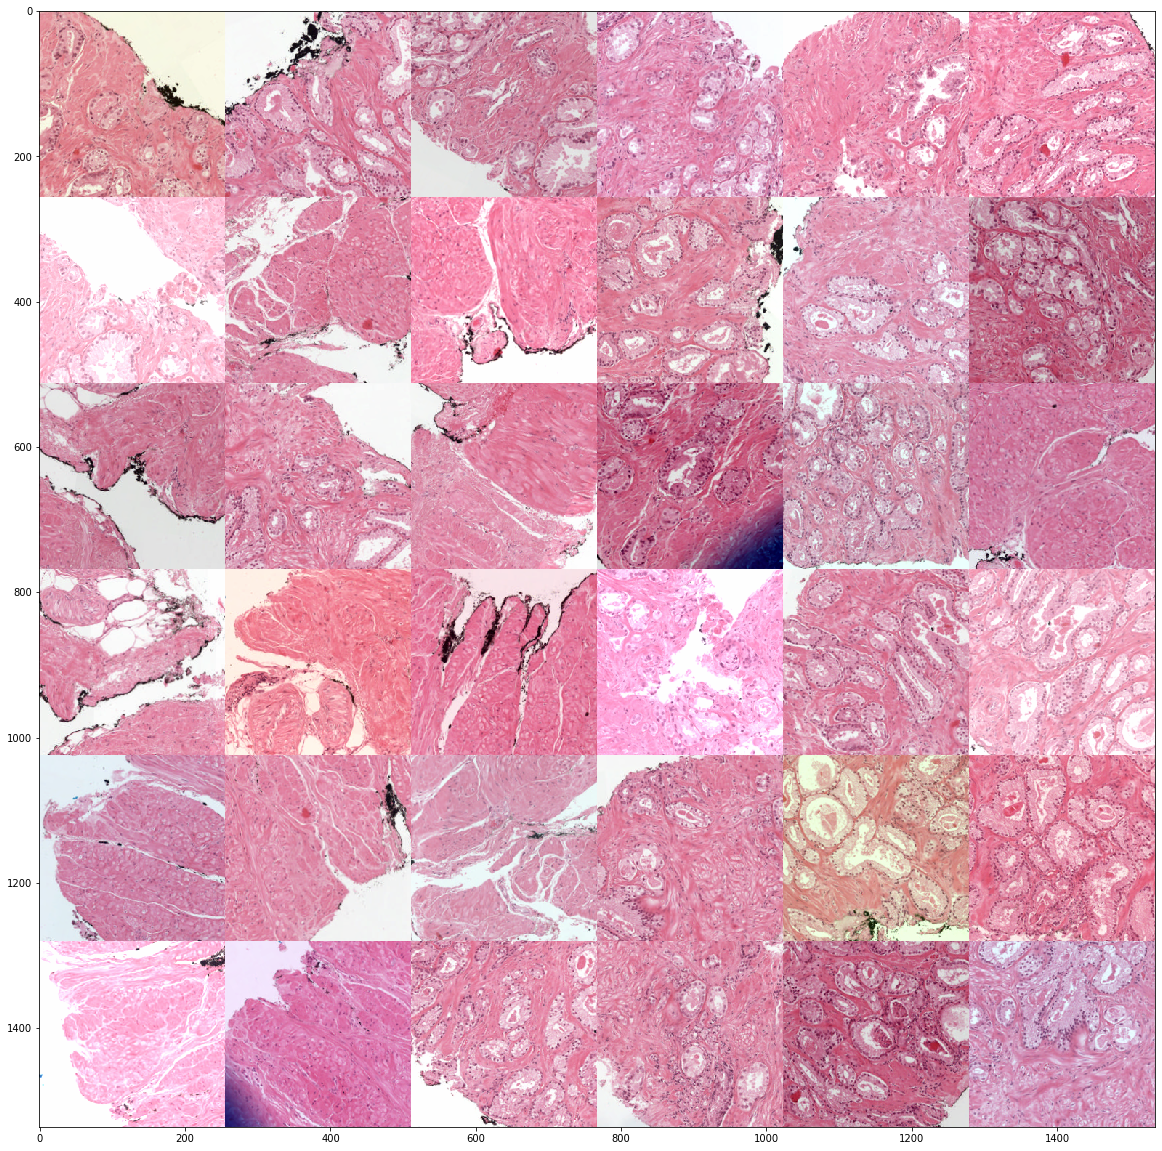

In [34]:
plt.figure(figsize = (20,300))
plt.imshow(grid.numpy().transpose((1, 2, 0)))

### Plot masks

In [89]:
def overlay_mask_on_image(images, masks, center='radboud', alpha=0.8, max_size=(800, 800)):
    """Show a mask overlayed on a slide."""
    N = len(images)
    f, ax = plt.subplots(N//3,3, figsize=(18,22))

    for i in range(N):
        if i > N // 3 * 3:
            break
        slide_data = (images[i,...].numpy().transpose((1,2,0)) + 1) / 2 * 255
        mask_data = masks[i,...].numpy()
                
        # Create alpha mask
        alpha_int = int(round(255*alpha))
        if center == 'radboud':
            alpha_content = np.less(mask_data, 2).astype('uint8') * alpha_int + (255 - alpha_int)
        elif center == 'karolinska':
            alpha_content = np.less(mask_data, 1).astype('uint8') * alpha_int + (255 - alpha_int)

        alpha_content = PIL.Image.fromarray(alpha_content)
        preview_palette = np.zeros(shape=768, dtype=int)

        if center == 'radboud':
            # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
            preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
        elif center == 'karolinska':
            # Mapping: {0: background, 1: benign, 2: cancer}
            preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)
        
        mask_data = PIL.Image.fromarray(mask_data)
        slide_data = PIL.Image.fromarray(np.uint8(slide_data))
        mask_data.putpalette(data=preview_palette.tolist())
        mask_rgb = mask_data.convert(mode='RGB')
        overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
        overlayed_image.thumbnail(size=max_size, resample=0)
        
        if N // 3 > 1:
            ax[i//3, i%3].imshow(overlayed_image) 
            ax[i//3, i%3].axis('off')
        else:
            ax[i%3].imshow(overlayed_image) 
            ax[i%3].axis('off')


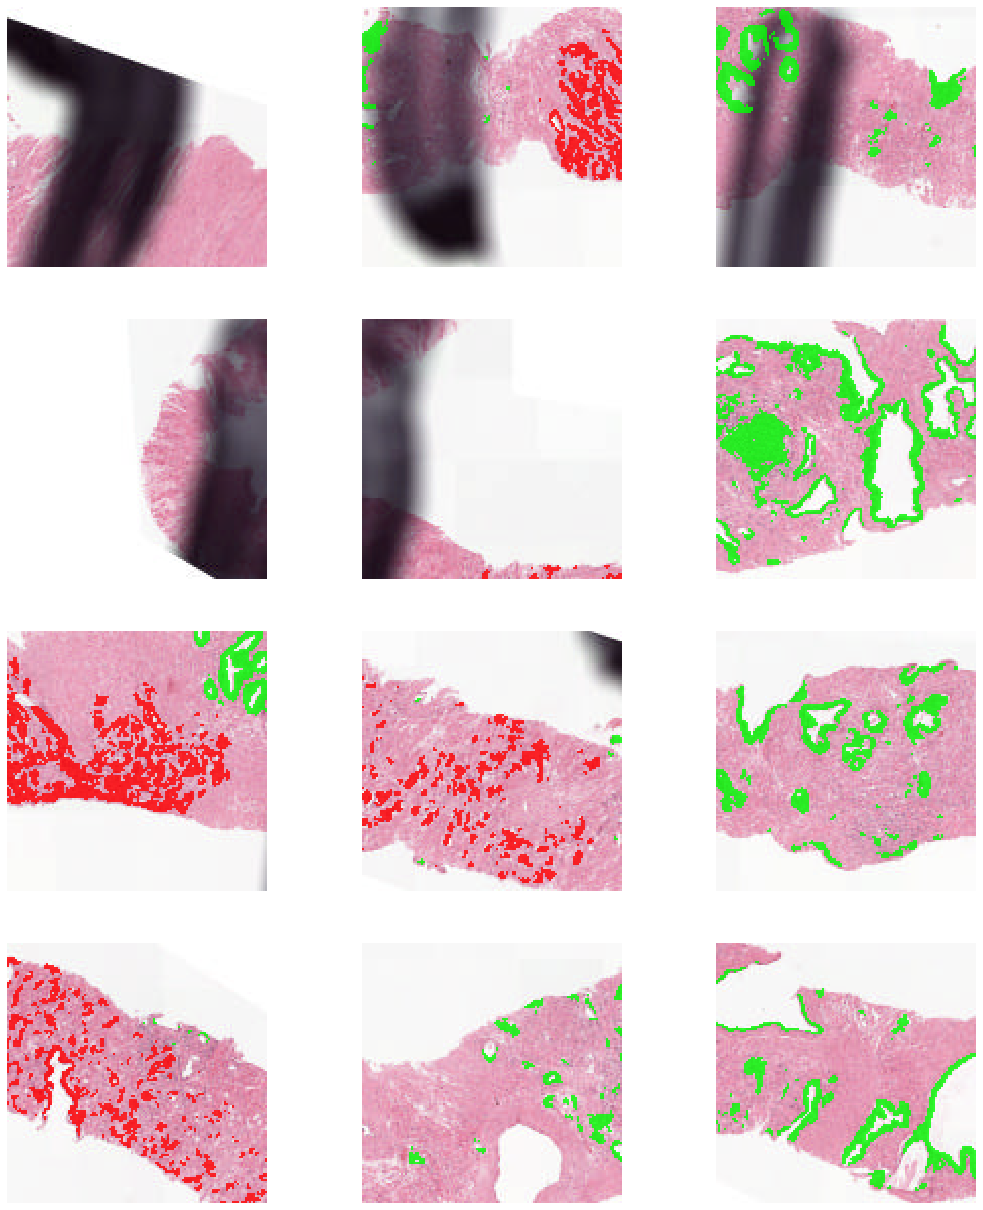

In [90]:
overlay_mask_on_image(img[0], target[0], center='radboud', alpha=0.8, max_size=(800, 800))

### Using cross validation

In [12]:
class crossValInx(object):
    def __init__(self, csv_file):
        self.crossVal_csv = pd.read_csv(csv_file)

    def __call__(self, fold = 0):
        val_idx = self.crossVal_csv.index[self.crossVal_csv['split'] == fold].tolist()
        train_idx = list(set([x for x in range(len(self.crossVal_csv))]) - set(val_idx))
        return train_idx, val_idx

In [27]:
idxSplit = crossValInx(csv_file)
train_idx, val_idx = idxSplit(3)

In [28]:
train = torch.utils.data.Subset(dataset, train_idx)
val = torch.utils.data.Subset(dataset, val_idx)

In [36]:
trainloader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True, num_workers=0, collate_fn=dataloader_collte_fn, pin_memory=True)
valloader = torch.utils.data.DataLoader(val, batch_size=bs, shuffle=True, num_workers=0, collate_fn=dataloader_collte_fn, pin_memory=True)

In [37]:
img, target = iter(trainloader).next()

In [39]:
print("image size:{}, target sise:{}.".format(img.size(), target.size()))

image size:torch.Size([4, 12, 3, 128, 128]), target sise:torch.Size([4]).
